In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking',
'home': '/home/vvalenzuela/MOAD/analysis-vicente/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/animations'}

In [3]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [4]:
#Definitions
start = datetime(2023, 1, 1) #Start date
length = 30 # Set Time length [days] 

In [5]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(start,path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [6]:
fname_bio = []
fname_sal =[]
for i in range(0,length+1):
    fname_bio.append(make_prefix(start+timedelta(i),path['NEMO'])+'_biol_T.nc')
    fname_sal.append(make_prefix(start+timedelta(i),path['NEMO'])+'_grid_T.nc')    

In [7]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [8]:
clat = [49.2]
clon = [-123.4]
#
a, b = finder(clat[0], clon[0])

In [9]:
ratio = 6.6

$$\textbf{From here working with monthly data to get DOC values}$$

If not POC, it may be a relation with Dissolved Organic Carbon and PBDEs states


In [10]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

In [11]:
path_months = '/results2/SalishSea/month-avg.202111/'

In [12]:
def monthly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

In [13]:
def month_year_bio_data(model_year_datetime):
    fname_bio_monthly = []
    months = 12
    for i in range(1,months+1):
        fname_bio_monthly.append(monthly_prefix(model_year_datetime+relativedelta(month=i),path_months, area='biol_T_'))
    #
    return fname_bio_monthly 

In [14]:
def doc_data(bio_dataset):
    #
    doc = xr.open_dataset(bio_dataset)['dissolved_organic_nitrogen']*ratio
    doc = doc.where(doc != 0, np.nan)
    #
    if (doc.dims[0] == 'time_counter') or (doc.dims[1] == 'deptht') or (doc.dims[2] == 'y') or (doc.dims[3] == 'x'):
        doc = doc.rename({'x' : 'gridX', 'y' : 'gridY', 'deptht' : 'depth', 'time_counter' : 'gridX'})
    else:
        #poc = xr.open_dataset(bio_dataset)['particulate_organic_nitrogen']*(16/106)
        doc = xr.open_dataset(bio_dataset)['dissolved_organic_nitrogen']*ratio
        doc = doc.where(doc != 0, np.nan)
   
    box_gridX = [[110, 250], [150, 350], [280, 370]]
    box_gridY = [[560, 730], [400, 560], [310, 400]]
    #
    #### Take slices of data for the three different regions:
    NSoG = doc.isel(gridY=slice(box_gridY[0][0],box_gridY[0][1]), gridX=slice(box_gridX[0][0],box_gridX[0][1]))
    CSoG = doc.isel(gridY=slice(box_gridY[1][0],box_gridY[1][1]), gridX=slice(box_gridX[1][0],box_gridX[1][1]))
    SSoG = doc.isel(gridY=slice(box_gridY[2][0],box_gridY[2][1]), gridX=slice(box_gridX[2][0],box_gridX[2][1]))
    #
    return NSoG, CSoG, SSoG

In [15]:
NSoG, CSoG, SSoG = doc_data(month_year_bio_data(datetime(2023,1,1))[0][0])

Plotting for looking at how it's changing in depth for one averaged month

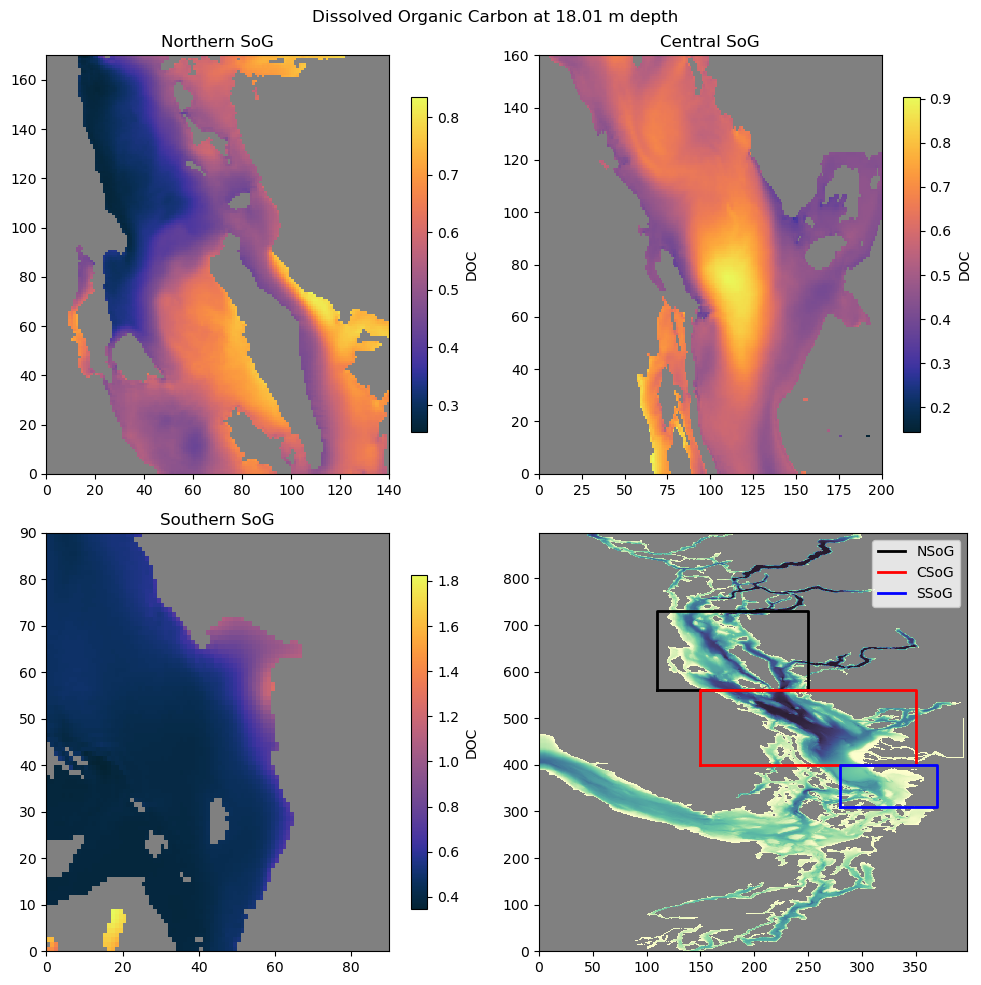

In [16]:
bathymetry = xr.open_dataset(path['bat']).Bathymetry
dd = 17
cmap_doc = cmocean.cm.thermal
cmap_doc.set_bad('grey')
cmap.set_bad('grey')
#
fig, ax = plt.subplots(2,2,figsize=(10,10))
north = ax[0,0].pcolormesh(NSoG[0,dd,:,:], cmap=cmap_doc)
central = ax[0,1].pcolormesh(CSoG[0,dd,:,:], cmap=cmap_doc)
south = ax[1,0].pcolormesh(SSoG[0,dd,:,:], cmap=cmap_doc)
#
ax[1,1].pcolormesh(bathymetry, cmap=cmap)
ax[1,1].plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
ax[1,1].plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
ax[1,1].plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
ax[1,1].legend()
#
ax[0,0].set_title('Northern SoG')
ax[0,1].set_title('Central SoG')
ax[1,0].set_title('Southern SoG')
#
cbar = fig.colorbar(north, ax=ax[0,0], location='right', shrink=0.8)
cbar.set_label('DOC')
#
cbar1 = fig.colorbar(central, ax=ax[0,1], location='right', shrink=0.8)
cbar1.set_label('DOC')
#
cbar2 = fig.colorbar(south, ax=ax[1,0], location='right', shrink=0.8)
cbar2.set_label('DOC')
#
plt.suptitle('Dissolved Organic Carbon at ' + str(np.round(NSoG.depth.values[dd], 2)) + ' m depth')
#
plt.tight_layout()


Lets calculate the depth mean for each one of these regions:

In [17]:
NSoG_mean = np.mean(NSoG[0,:,:,:], axis=0)
CSoG_mean = np.mean(CSoG[0,:,:,:], axis=0)
SSoG_mean = np.mean(SSoG[0,:,:,:], axis=0)

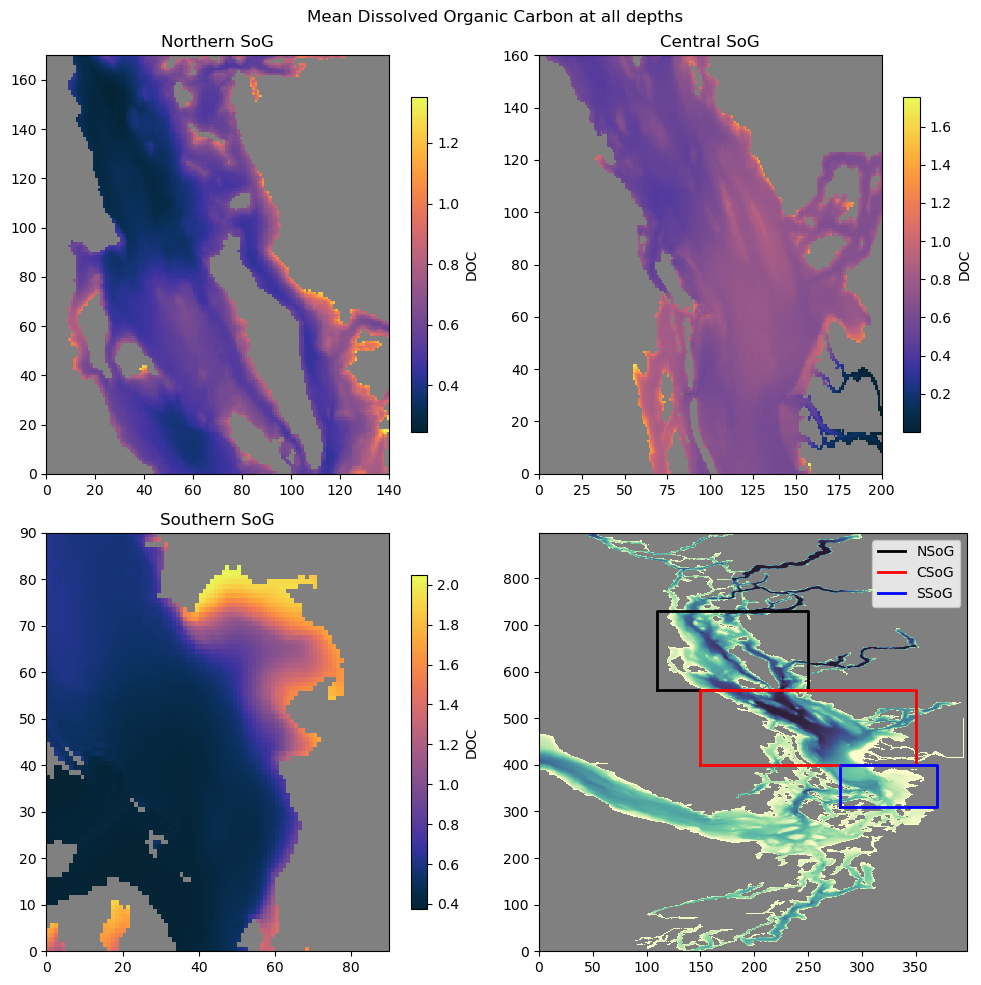

In [18]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
north = ax[0,0].pcolormesh(NSoG_mean, cmap=cmap_doc)
central = ax[0,1].pcolormesh(CSoG_mean, cmap=cmap_doc)
south = ax[1,0].pcolormesh(SSoG_mean, cmap=cmap_doc)
#
ax[1,1].pcolormesh(bathymetry, cmap=cmap)
ax[1,1].plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
ax[1,1].plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
ax[1,1].plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
ax[1,1].legend()
#
ax[0,0].set_title('Northern SoG')
ax[0,1].set_title('Central SoG')
ax[1,0].set_title('Southern SoG')
#
cbar = fig.colorbar(north, ax=ax[0,0], location='right', shrink=0.8)
cbar.set_label('DOC')
#
cbar1 = fig.colorbar(central, ax=ax[0,1], location='right', shrink=0.8)
cbar1.set_label('DOC')
#
cbar2 = fig.colorbar(south, ax=ax[1,0], location='right', shrink=0.8)
cbar2.set_label('DOC')
#
plt.suptitle('Mean Dissolved Organic Carbon at all depths')
#
plt.tight_layout()

Now, lets calculate the mean for all the regions, having just a single values for each one of them:

In [19]:
DOC_NSoG = np.mean(NSoG_mean).values
DOC_CSoG = np.mean(CSoG_mean).values
DOC_SSoG = np.mean(SSoG_mean).values

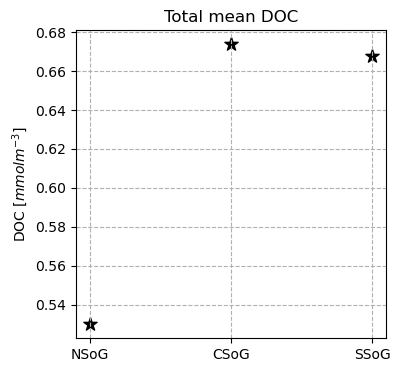

In [20]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(['NSoG','CSoG','SSoG'], [DOC_NSoG, DOC_CSoG, DOC_SSoG], c = 'k', marker = '*', s=100)
ax.set_ylabel(r'DOC [$mmol m^{-3}$]')
ax.set_title('Total mean DOC')
ax.grid(linestyle = '--')

Now, lets see how this 'total mean DOC' changes through the year:

In [21]:
DOC_NSoG_year = []
DOC_CSoG_year = []
DOC_SSoG_year = []
for i in range(0, 12):
    NSoG_year, CSoG_year, SSoG_year = doc_data(month_year_bio_data(datetime(2023,1,1))[i][0])
    #
    DOC_NSoG_year.append(np.mean(NSoG_year[0,:,:,:]))
    DOC_CSoG_year.append(np.mean(CSoG_year[0,:,:,:]))
    DOC_SSoG_year.append(np.mean(SSoG_year[0,:,:,:]))        

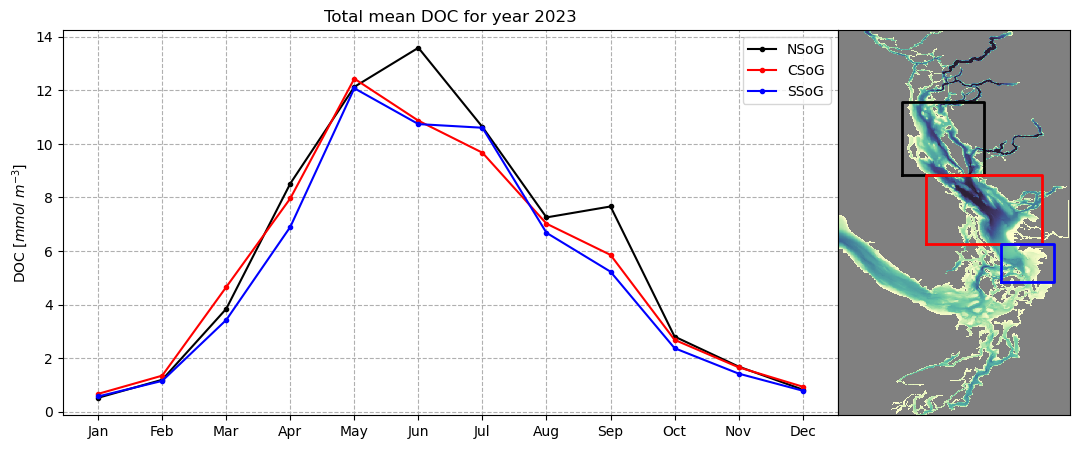

In [22]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(meses, DOC_NSoG_year, '.-k', label = 'NSoG')
ax.plot(meses, DOC_CSoG_year, '.-r', label = 'CSoG')
ax.plot(meses, DOC_SSoG_year, '.-b', label = 'SSoG')
ax.legend(loc = 'upper right')
ax.set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax.set_title('Total mean DOC for year 2023')
ax.grid(linestyle = '--')
##### Small map for regions reference
#
axins = ax.inset_axes([1, 0, 0.3, 1])
#
prof = axins.pcolormesh(bathymetry, cmap=cmap)
axins.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
axins.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
axins.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

Now, for all the years in the Salish Sea Cast Model:

In [24]:
years_ssc = np.arange(2007, 2024, 1)

In [25]:
# Create pandas dataframes for easier manipulation an visualization of the data
DOC_NSoG_all = pd.DataFrame(columns = years_ssc, index = meses)
DOC_CSoG_all = pd.DataFrame(columns = years_ssc, index = meses)
DOC_SSoG_all = pd.DataFrame(columns = years_ssc, index = meses)

In [26]:
for year in years_ssc:
    for i in range(0, 12):
        NSoG_month, CSoG_month, SSoG_month = doc_data(month_year_bio_data(datetime(year,1,1))[i][0])
        #
        DOC_NSoG_all[year][i] = np.mean(NSoG_month).values
        DOC_CSoG_all[year][i] = np.mean(CSoG_month).values
        DOC_SSoG_all[year][i] = np.mean(SSoG_month).values           

In [27]:
DOC_NSoG_all[2008]['Jun'] = (DOC_NSoG_all[2008]['May'] + DOC_NSoG_all[2008]['Jul'])/2
DOC_CSoG_all[2008]['Jun'] = (DOC_CSoG_all[2008]['May'] + DOC_CSoG_all[2008]['Jul'])/2
DOC_SSoG_all[2008]['Jun'] = (DOC_SSoG_all[2008]['May'] + DOC_SSoG_all[2008]['Jul'])/2

Plot for all years in the different parts of the SoG:

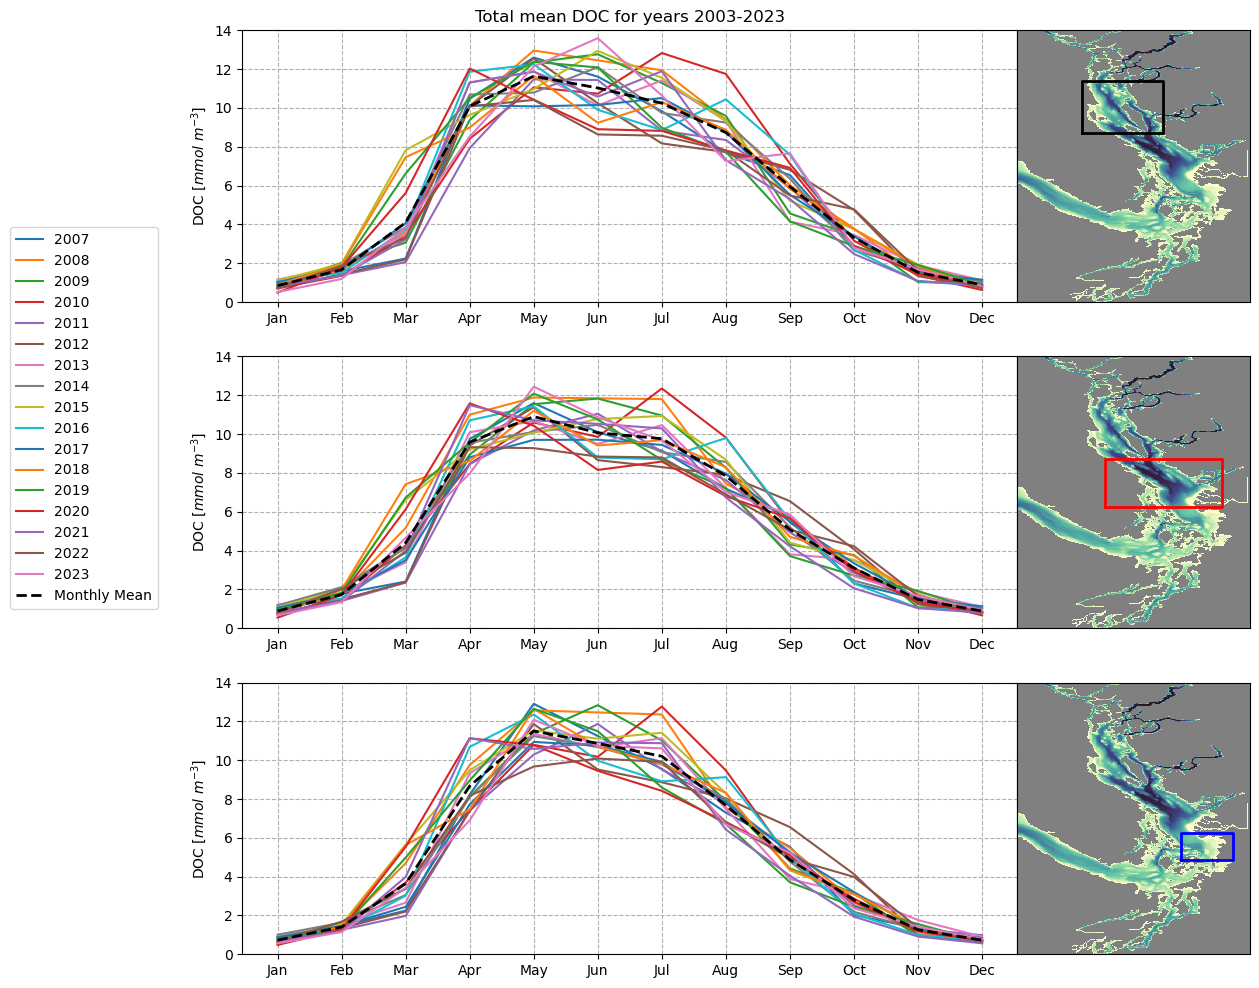

In [29]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(3,1,figsize=(10,12))
ax[0].plot(DOC_NSoG_all.index, DOC_NSoG_all, label = years_ssc)
ax[0].plot(DOC_CSoG_all.index, DOC_NSoG_all.mean(axis=1), '--k', linewidth=2, label='Monthly Mean')
ax[0].legend(loc = 'upper right', bbox_to_anchor=(-0.1, 0.3))
ax[0].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax[0].set_title('Total mean DOC for years 2003-2023')
ax[0].grid(linestyle = '--')
ax[0].set_ylim(0,14)
#
ax[1].plot(DOC_CSoG_all.index, DOC_CSoG_all)
ax[1].plot(DOC_CSoG_all.index, DOC_CSoG_all.mean(axis=1), '--k', linewidth=2)
ax[1].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax[1].grid(linestyle = '--')
ax[1].set_ylim(0,14)
#
ax[2].plot(DOC_SSoG_all.index, DOC_SSoG_all)
ax[2].plot(DOC_CSoG_all.index, DOC_SSoG_all.mean(axis=1), '--k', linewidth=2)
ax[2].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax[2].grid(linestyle = '--')
ax[2].set_ylim(0,14)
#
#
axins0 = ax[0].inset_axes([1, 0, 0.3, 1])
axins0.pcolormesh(bathymetry, cmap=cmap)
axins0.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
axins0.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#
#
axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
axins1.pcolormesh(bathymetry, cmap=cmap)
axins1.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#
#
axins2 = ax[2].inset_axes([1, 0, 0.3, 1])
axins2.pcolormesh(bathymetry, cmap=cmap)
axins2.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
axins2.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

Text(0.5, 1.0, 'Ratio between DOC and Mean POC ($DOC/DOC_{mean}$)')

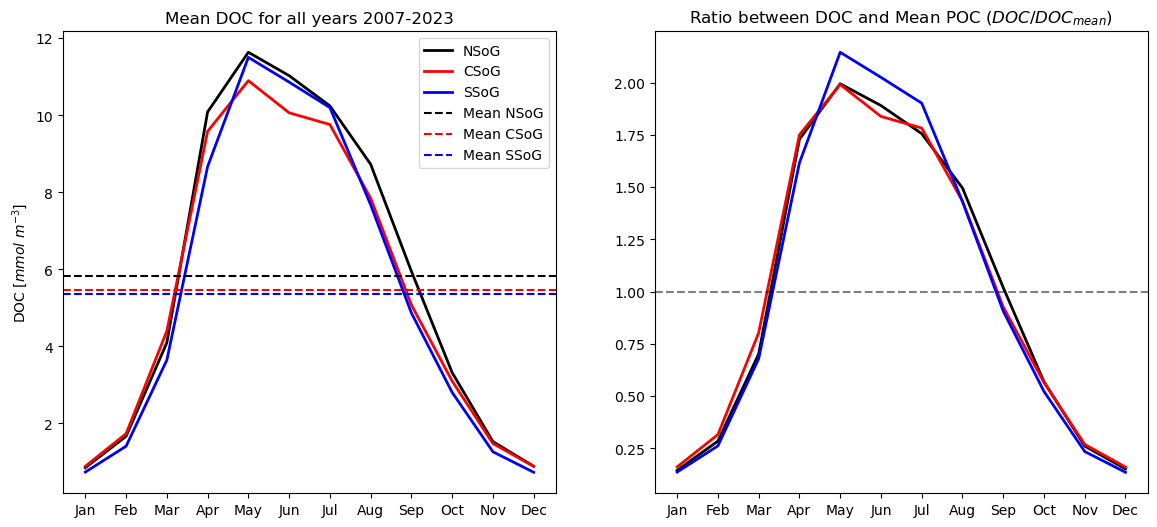

In [31]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(DOC_NSoG_all.index, DOC_NSoG_all.mean(axis=1), '-k', linewidth=2, label='NSoG')
ax[0].plot(DOC_CSoG_all.index, DOC_CSoG_all.mean(axis=1), '-r', linewidth=2, label='CSoG')
ax[0].plot(DOC_SSoG_all.index, DOC_SSoG_all.mean(axis=1), '-b', linewidth=2, label='SSoG')
#
ax[0].axhline(y=np.mean(DOC_NSoG_all.mean(axis=1)), color = 'k', linestyle = '--', label = 'Mean NSoG')
ax[0].axhline(y=np.mean(DOC_CSoG_all.mean(axis=1)), color = 'r', linestyle = '--', label = 'Mean CSoG')
ax[0].axhline(y=np.mean(DOC_SSoG_all.mean(axis=1)), color = 'b', linestyle = '--', label = 'Mean SSoG')
#
ax[0].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
#
ax[0].legend()
#
ax[0].set_title('Mean DOC for all years 2007-2023')
#
#
ax[1].plot(DOC_NSoG_all.index, DOC_NSoG_all.mean(axis=1)/np.mean(DOC_NSoG_all.mean(axis=1)), '-k', linewidth=2, label='NSoG')
ax[1].plot(DOC_CSoG_all.index, DOC_CSoG_all.mean(axis=1)/np.mean(DOC_CSoG_all.mean(axis=1)), '-r', linewidth=2, label='CSoG')
ax[1].plot(DOC_SSoG_all.index, DOC_SSoG_all.mean(axis=1)/np.mean(DOC_SSoG_all.mean(axis=1)), '-b', linewidth=2, label='SSoG')
ax[1].axhline(y=1, color = 'k', linestyle = '--', alpha = 0.5)
ax[1].set_title(r'Ratio between DOC and Mean POC ($DOC/DOC_{mean}$)')
#

In [32]:
print('Mean DOC Value for NSoG: ' + str(np.mean(DOC_NSoG_all.mean(axis=1))) + ' in $mmol m^{-3}$')
print('Mean DOC Value for CSoG: ' + str(np.mean(DOC_CSoG_all.mean(axis=1))) + ' in $mmol m^{-3}$')
print('Mean DOC Value for SSoG: ' + str(np.mean(DOC_SSoG_all.mean(axis=1))) + ' in $mmol m^{-3}$')
seasonal_mean_NSoG_all = np.mean(DOC_NSoG_all.mean(axis=1))
seasonal_mean_CSoG_all = np.mean(DOC_CSoG_all.mean(axis=1))
seasonal_mean_SSoG_all = np.mean(DOC_SSoG_all.mean(axis=1))

Mean DOC Value for NSoG: 5.833506200827805 in $mmol m^{-3}$
Mean DOC Value for CSoG: 5.474428480746699 in $mmol m^{-3}$
Mean DOC Value for SSoG: 5.362624570435169 in $mmol m^{-3}$


In [29]:
#conversion = (12.0107*10**(-12))

In [30]:
#print('Mean POC Value for NSoG: ' + str(np.mean(POC_NSoG_all.mean(axis=1))*conversion) + ' in $Kg / L$')
#print('Mean POC Value for CSoG: ' + str(np.mean(POC_CSoG_all.mean(axis=1))*conversion) + ' in $Kg / L$')
#print('Mean POC Value for SSoG: ' + str(np.mean(POC_SSoG_all.mean(axis=1))*conversion) + ' in $Kg / L$')

Mean POC Value for NSoG: 5.129545085444791e-13 in $Kg / L$
Mean POC Value for CSoG: 4.863637397807658e-13 in $Kg / L$
Mean POC Value for SSoG: 5.456801462368418e-13 in $Kg / L$


Table of mean POC values per region:


|| Northern Strait of Georgia | Central Strait of Georgia | Sothern Strait of Georgia |
|--------------------------| -------------------------- | ------------------------- | ------------------------- |
| $\textbf{DOC}$ $[mmol m^{-3}]$ | $\textbf{5.83}$ |  $\textbf{5.47}$ |  $\textbf{5.36}$ |



In [44]:
#fig, ax = plt.subplots(1,2,figsize=(14,4))
#ax[0].scatter(['NSoG','CSoG','SSoG'], [seasonal_mean_NSoG_all, seasonal_mean_CSoG_all, seasonal_mean_SSoG_all], c = ['k','r','b'], marker = '*', s=100)
#ax[0].set_ylabel(r'POC [$mmol \cdot m^{-3}$]')
#ax[0].set_title('Total mean POC (2007-2023)')
#ax[0].grid(linestyle = '--')
#
#ax[1].scatter(['NSoG','CSoG','SSoG'], [seasonal_mean_NSoG_all*conversion, seasonal_mean_CSoG_all*conversion, seasonal_mean_SSoG_all*conversion], c = ['k','r','b'], marker = '*', s=100)
#ax[1].set_ylabel(r'POC [$Kg/L$]')
#ax[1].set_title('Total mean POC (2007-2023)')
#ax[1].grid(linestyle = '--')
#
#axins = ax[1].inset_axes([1, 0, 0.3, 1])
#
#prof = axins.pcolormesh(bathymetry, cmap=cmap)
#axins.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
#axins.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
#axins.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
#axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

Lets check our equation again:


From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$


Assuming that $K_{oc,a}$ is a constant, then we can get the following relation for POC:

$[POC] = \frac{[PBDE]_p}{[PBDE]_{d,c}} \cdot \frac{1}{K_{oc,a}}$


So, 


- IF $[POC]$ is HIGH $\Rightarrow$ HIGH $[PBDE]_p$ is expected 

- IF $[POC]$ is LOW $\Rightarrow$ HIGH $[PBDE]_{d,c}$ is expected 



Now, letk look at the differences between POC values and the background POC concentrations

In [33]:
NSoG_mean_seasonal = DOC_NSoG_all.mean(axis=1)
CSoG_mean_seasonal = DOC_CSoG_all.mean(axis=1)
SSoG_mean_seasonal = DOC_SSoG_all.mean(axis=1)

In [35]:
for i in range(0,len(years_ssc)):
    fig, ax = plt.subplots(3,2,figsize=(14,10))
    #
    diff_NSoG = np.array((DOC_NSoG_all[years_ssc[i]].astype(float).values - NSoG_mean_seasonal.astype(float).values))
    ax[0,0].plot(DOC_NSoG_all.index, DOC_NSoG_all[years_ssc[i]], '-k', label = str(years_ssc[i]))
    ax[0,0].plot(DOC_NSoG_all.index, NSoG_mean_seasonal, '--k', linewidth=2, alpha = 0.5, label='Total Mean')
    ax[0,0].set_ylabel(r'NSoG DOC [$mmol\ m^{-3}$]')
    ax[0,0].legend(loc = 'upper right')
    ax[0,0].set_title(str(years_ssc[i]) + r' mean and total years mean')
    ax[0,0].grid(linestyle = '--')
    ax[0,0].set_ylim(0,13)
    #
    ax[0,1].fill_between(meses, diff_NSoG ,0 , where=(diff_NSoG >= 0), interpolate=True, color='red', alpha=1, label = 'DOC above total mean')
    ax[0,1].fill_between(meses, diff_NSoG ,0 , where=(diff_NSoG < 0), interpolate=True, color='red', alpha=0.5, label = 'DOC below total mean')
    ax[0,1].plot(meses, diff_NSoG, 'k', alpha = 0.5)
    ax[0,1].set_ylim(-4, 4)
    ax[0,1].legend()
    ax[0,1].grid(linestyle = '--')
    ax[0,1].set_title(str(years_ssc[i]) + r' mean and total years mean difference')
    #
    axins0 = ax[0,1].inset_axes([1, 0, 0.3, 1])
    axins0.pcolormesh(bathymetry, cmap=cmap)
    axins0.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
    axins0.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################
    diff_CSoG = np.array((DOC_CSoG_all[years_ssc[i]].astype(float).values - CSoG_mean_seasonal.astype(float).values))
    ax[1,0].plot(DOC_CSoG_all.index, DOC_CSoG_all[years_ssc[i]], '-r', label = str(years_ssc[i]))
    ax[1,0].plot(DOC_CSoG_all.index, CSoG_mean_seasonal, '--r', linewidth=2, alpha = 0.5, label='Total Mean')
    ax[1,0].set_ylabel(r'CSoG DOC [$mmol\ m^{-3}$]')
    ax[1,0].legend(loc = 'upper right')
    ax[1,0].grid(linestyle = '--')
    ax[1,0].set_ylim(0,13)
    #
    ax[1,1].fill_between(meses, diff_CSoG ,0 , where=(diff_CSoG >= 0), interpolate=True, color='red', alpha=1, label = 'DOC above total mean')
    ax[1,1].fill_between(meses, diff_CSoG ,0 , where=(diff_CSoG < 0), interpolate=True, color='red', alpha=0.5, label = 'DOC below total mean')
    ax[1,1].plot(meses, diff_CSoG, 'k', alpha = 0.5)
    ax[1,1].set_ylim(-4, 4)
    ax[1,1].legend()
    ax[1,1].grid(linestyle = '--')
    #
    axins1 = ax[1,1].inset_axes([1, 0, 0.3, 1])
    axins1.pcolormesh(bathymetry, cmap=cmap)
    axins1.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################
    diff_SSoG = np.array((DOC_SSoG_all[years_ssc[i]].astype(float).values - SSoG_mean_seasonal.astype(float).values))
    ax[2,0].plot(DOC_SSoG_all.index, DOC_SSoG_all[years_ssc[i]], '-b', label = str(years_ssc[i]))
    ax[2,0].plot(DOC_SSoG_all.index, SSoG_mean_seasonal, '--b', linewidth=2, alpha = 0.5, label='Total Mean')
    ax[2,0].set_ylabel(r'SSoG DOC [$mmol\ m^{-3}$]')
    ax[2,0].legend(loc = 'upper right')
    ax[2,0].grid(linestyle = '--')
    ax[2,0].set_ylim(0,13)
    #
    ax[2,1].fill_between(meses, diff_SSoG ,0 , where=(diff_SSoG >= 0), interpolate=True, color='red', alpha=1, label = 'DOC above total mean')
    ax[2,1].fill_between(meses, diff_SSoG ,0 , where=(diff_SSoG < 0), interpolate=True, color='red', alpha=0.5, label = 'DOC below total mean')
    ax[2,1].plot(meses, diff_SSoG, 'k', alpha = 0.5)
    ax[2,1].set_ylim(-4, 4)
    ax[2,1].legend()
    ax[2,1].grid(linestyle = '--')
    #
    axins2 = ax[2,1].inset_axes([1, 0, 0.3, 1])
    axins2.pcolormesh(bathymetry, cmap=cmap)
    axins2.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
    axins2.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()
    #
    path1 = os.path.join(r'/home/vvalenzuela/MOAD/POC/POC_years_plots')
    file = os.path.join(path1, str(years_ssc[i]) + '_DOC_mean_and_diff.png')
    plt.savefig(file)    
    #
    plt.close()

Lets now check some statistics:

- See how each year POC is compared to the mean values calculated before

In [36]:
quartiles_DOC_NSoG = pd.DataFrame(index= ['Q1', 'Q2', 'Q3'], columns=years_ssc)
quartiles_DOC_CSoG = pd.DataFrame(index= ['Q1', 'Q2', 'Q3'], columns=years_ssc)
quartiles_DOC_SSoG = pd.DataFrame(index= ['Q1', 'Q2', 'Q3'], columns=years_ssc)

In [37]:
for i in years_ssc:
    quartiles_DOC_NSoG[i] = DOC_NSoG_all[i].quantile([0.25, 0.5, 0.75]).values
    quartiles_DOC_CSoG[i] = DOC_CSoG_all[i].quantile([0.25, 0.5, 0.75]).values
    quartiles_DOC_SSoG[i] = DOC_SSoG_all[i].quantile([0.25, 0.5, 0.75]).values

In [38]:
max_doc_NSoG = []
min_doc_NSoG = []
max_doc_CSoG = []
min_doc_CSoG = []
max_doc_SSoG = []
min_doc_SSoG = []
#
mean_doc_NSoG = []
mean_doc_CSoG = []
mean_doc_SSoG = []
#
for y in years_ssc:
    max_doc_NSoG.append(DOC_NSoG_all[y].max())
    min_doc_NSoG.append(DOC_NSoG_all[y].min())
    max_doc_CSoG.append(DOC_CSoG_all[y].max())
    min_doc_CSoG.append(DOC_CSoG_all[y].min()) 
    max_doc_SSoG.append(DOC_SSoG_all[y].max())
    min_doc_SSoG.append(DOC_SSoG_all[y].min())    
    mean_doc_NSoG.append(DOC_NSoG_all[y].mean()) 
    mean_doc_CSoG.append(DOC_CSoG_all[y].mean())
    mean_doc_SSoG.append(DOC_SSoG_all[y].mean())      

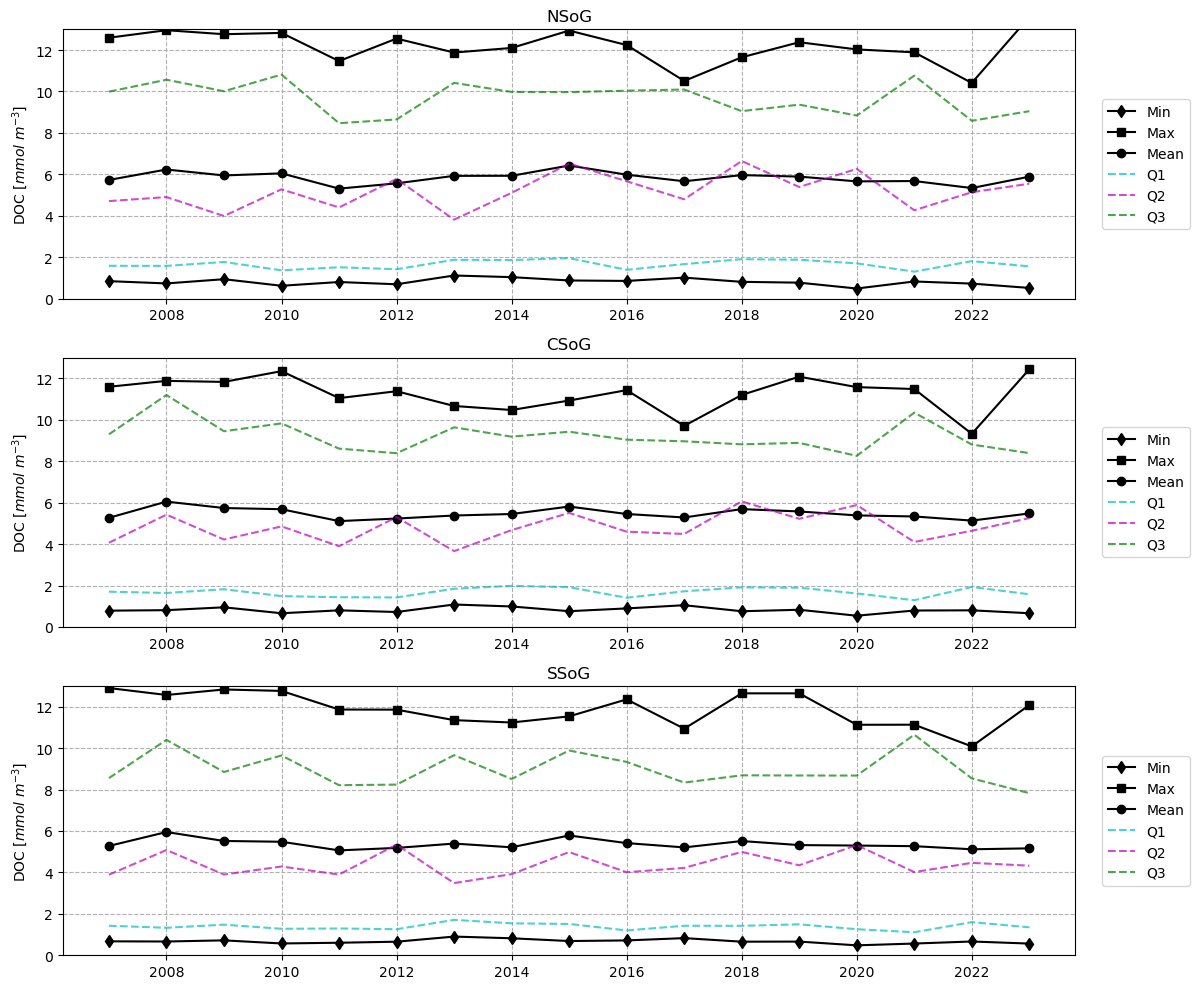

In [39]:
fig, ax = plt.subplots(3,1, figsize=(12,10))
ax[0].plot(DOC_NSoG_all.columns, min_doc_NSoG, '-dk', label = 'Min')
ax[0].plot(DOC_NSoG_all.columns, max_doc_NSoG, '-sk', label = 'Max')
ax[0].plot(DOC_SSoG_all.columns, mean_doc_NSoG, '-ok', label = 'Mean')
ax[0].plot(DOC_NSoG_all.columns, quartiles_DOC_NSoG.iloc[0], '--c', alpha = 0.7, label = 'Q1')
ax[0].plot(DOC_NSoG_all.columns, quartiles_DOC_NSoG.iloc[1], '--m', alpha = 0.7, label = 'Q2')
ax[0].plot(DOC_NSoG_all.columns, quartiles_DOC_NSoG.iloc[2], '--g', alpha = 0.7, label = 'Q3')
ax[0].grid(linestyle = '--')
ax[0].set_title('NSoG')
ax[0].legend(loc = 'right', bbox_to_anchor=(1.12, 0.5))
ax[0].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax[0].set_ylim(0, 13)
#
#
ax[1].plot(DOC_NSoG_all.columns, min_doc_CSoG, '-dk', label = 'Min')
ax[1].plot(DOC_NSoG_all.columns, max_doc_CSoG, '-sk', label = 'Max')
ax[1].plot(DOC_SSoG_all.columns, mean_doc_CSoG, '-ok', label = 'Mean')
ax[1].plot(DOC_NSoG_all.columns, quartiles_DOC_CSoG.iloc[0], '--c', alpha = 0.7, label = 'Q1')
ax[1].plot(DOC_NSoG_all.columns, quartiles_DOC_CSoG.iloc[1], '--m', alpha = 0.7, label = 'Q2')
ax[1].plot(DOC_NSoG_all.columns, quartiles_DOC_CSoG.iloc[2], '--g', alpha = 0.7, label = 'Q3')
ax[1].grid(linestyle = '--')
ax[1].set_title('CSoG')
ax[1].legend(loc = 'right', bbox_to_anchor=(1.12, 0.5))
ax[1].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax[1].set_ylim(0, 13)
#
#
ax[2].plot(DOC_NSoG_all.columns, min_doc_SSoG, '-dk', label = 'Min')
ax[2].plot(DOC_NSoG_all.columns, max_doc_SSoG, '-sk', label = 'Max')
ax[2].plot(DOC_SSoG_all.columns, mean_doc_SSoG, '-ok', label = 'Mean')
ax[2].plot(DOC_NSoG_all.columns, quartiles_DOC_SSoG.iloc[0], '--c', alpha = 0.7, label = 'Q1')
ax[2].plot(DOC_NSoG_all.columns, quartiles_DOC_SSoG.iloc[1], '--m', alpha = 0.7, label = 'Q2')
ax[2].plot(DOC_NSoG_all.columns, quartiles_DOC_SSoG.iloc[2], '--g', alpha = 0.7, label = 'Q3')
ax[2].grid(linestyle = '--')
ax[2].set_title('SSoG')
ax[2].legend(loc = 'right', bbox_to_anchor=(1.12, 0.5))
ax[2].set_ylabel(r'DOC [$mmol\ m^{-3}$]')
ax[2].set_ylim(0, 13)
#
#
plt.tight_layout()

Get the lats and lons of the regions to use in Ocean Parcels

In [53]:
X_grid_NS = [110, 110, 250, 250, 110]
Y_grid_NS = [560, 730, 730, 560, 560]
X_grid_CS = [150, 150, 350, 350, 150] 
Y_grid_CS = [400, 560, 560, 400, 400]
X_grid_SS = [280, 280, 370, 370, 280]
Y_grid_SS = [310, 400, 400, 310, 310]

In [54]:
bathy = xr.open_dataset(path['bat'])
model_lat = bathy.nav_lat.values
model_lon = bathy.nav_lon.values

In [55]:
lats_NS = np.zeros(len(X_grid_NS))
lons_NS = np.zeros_like(lats_NS)
lats_CS = np.zeros_like(lats_NS)
lons_CS = np.zeros_like(lats_NS)
lats_SS = np.zeros_like(lats_NS)
lons_SS = np.zeros_like(lats_NS)
for i in range(0,len(X_grid_NS)): 
    lats_NS[i] = bathy.nav_lat[Y_grid_NS[i],X_grid_NS[i]].values
    lons_NS[i] = bathy.nav_lon[Y_grid_NS[i],X_grid_NS[i]].values
    lats_CS[i] = bathy.nav_lat[Y_grid_CS[i],X_grid_CS[i]].values
    lons_CS[i] = bathy.nav_lon[Y_grid_CS[i],X_grid_CS[i]].values
    lats_SS[i] = bathy.nav_lat[Y_grid_SS[i],X_grid_SS[i]].values
    lons_SS[i] = bathy.nav_lon[Y_grid_SS[i],X_grid_SS[i]].values    


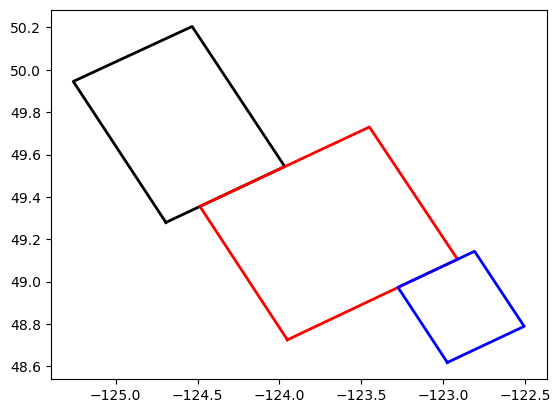

In [41]:
plt.plot(lons_NS,lats_NS, '-k', linewidth = 2, label='NSoG')
plt.plot(lons_CS,lats_CS, '-r', linewidth = 2, label='CSoG')
plt.plot(lons_SS,lats_SS, '-b', linewidth = 2, label='SSoG')

$$\textbf{Point to Point POC comparison between model POC and POC observations}$$

In [16]:
poc_model_SS[0]*6*12

array([280.0585], dtype=float32)

Sun et al. (2023) stations locations and names

In [4]:
stations = ['JF2', 'HS', 'S4-1.5', 'S2', 'NG', 'S1', 'S3', 'FR']
lat = np.array([48 + (18/60), 48 + (37.80/60) , 49 + (15/60) , 49 + (17.58/60) , 49 + (43.60/60), 49 + (12.32/60), 49 + (17.88/60), 49 + (08.66/60)])
lon = (-1) * np.array([124, 123 + (14.60/60), 123 + (40/60), 123 + (22.51/60), 124 + (40.80/60), 123 + (18/60), 123 + (04.91/60), 123 + (02.65/60)]) 

Stations sampling dates amd depths

In [18]:
# for S4-1.5 ---> Southern Strait
time_SS = [datetime(2017,5,9), datetime(2017,5,9), datetime(2017,9,15) ,datetime(2017,9,15) ,datetime(2018,1,25) ,datetime(2018,1,25) ,datetime(2018,4,12) ,datetime(2018,4,17), datetime(2018,8,10), datetime(2018,8,7)]
depth_SS = np.array([25, 150, 25, 150, 25, 150, 25, 150, 25, 150])
poc_SS_f = np.array([67.5, 45, 19, 19.5, 13.6, 15.6, 35.5, 25.8, 86.3, 25.4]) # ug/L
poc_SS_L = np.array([23.3, 2.1, 0.7, 1.3, 0.8, 0.4, 6.9, 1.5, 3.5, 0.4]) # ug/L
lat_SS = np.array([49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60)])
lon_SS = (-1) * np.array([123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60)])

#
# for NG ---> Northern Strait
time_NS = [datetime(2018,8,25), datetime(2018,8,24)]
depth_NS = np.array([25, 150])
poc_NS_f = np.array([21.7, 19.4]) # ug/L
poc_NS_L = np.array([0.9, 0.6]) # ug/L
lat_NS = np.array([49 + (43.60/60), 49 + (43.60/60)])
lon_NS = (-1) * np.array([124 + (40.80/60), 124 + (40.80/60)])

In [6]:
folder = make_prefix(datetime(2023, 1, 1),path['NEMO'],res='d')+'_biol_T.nc'

In [7]:
poc = xr.open_dataset(folder)['particulate_organic_nitrogen']*(106/16)

In [8]:
path_grid = '/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc'
grid = xr.open_dataset(path_grid)

In [57]:
grid_Y_SS = np.zeros(len(lat_SS)).astype(int)
grid_X_SS = np.zeros_like(grid_Y_SS)
poc_model_SS = []
gp_SS_i =[]
gp_SS_j =[]
for i in range(0,len(poc_SS_f)):
    folder = make_prefix(time_SS[i],path['NEMO'],res='d')+'_biol_T.nc'
    poc = xr.open_dataset(folder)['particulate_organic_nitrogen']*(106/16)
    #
    grid_Y_SS = grid.jj.sel(lats=lat_SS[i], lons=lon_SS[i], method='nearest').item()
    grid_X_SS = grid.ii.sel(lats=lat_SS[i], lons=lon_SS[i], method='nearest').item()
    gp_SS_i.append(grid_X_SS)
    gp_SS_j.append(grid_Y_SS)
    poc_model_SS.append((poc.sel(deptht = depth_SS[i], x = grid_X_SS, y = grid_Y_SS, method = 'nearest')).values)
poc_model_SS = np.array(poc_model_SS)*12 # Conversion to KG/L
#################################################################################################################
grid_Y_NS = np.zeros(len(lat_NS)).astype(int)
grid_X_NS = np.zeros_like(grid_Y_NS)
poc_model_NS = []
gp_NS_i =[]
gp_NS_j =[]
for i in range(0,len(poc_NS_f)):
    folder = make_prefix(time_NS[i],path['NEMO'],res='d')+'_biol_T.nc'
    poc = xr.open_dataset(folder)['particulate_organic_nitrogen']*(106/16)
    #
    grid_Y_NS = grid.jj.sel(lats=lat_NS[i], lons=lon_NS[i], method='nearest').item()
    grid_X_NS = grid.ii.sel(lats=lat_NS[i], lons=lon_NS[i], method='nearest').item()
    gp_NS_i.append(grid_X_NS)
    gp_NS_j.append(grid_Y_NS)    
    poc_model_NS.append((poc.sel(deptht = depth_NS[i], x = grid_X_NS, y = grid_Y_NS, method = 'nearest')).values)
poc_model_NS = np.array(poc_model_NS)*12 # Conversion to KG/L    

In [58]:
dd_s = depth_SS.astype(str).tolist()
dd_n = depth_NS.astype(str).tolist()
bathy = xr.open_dataset(path['bat'])

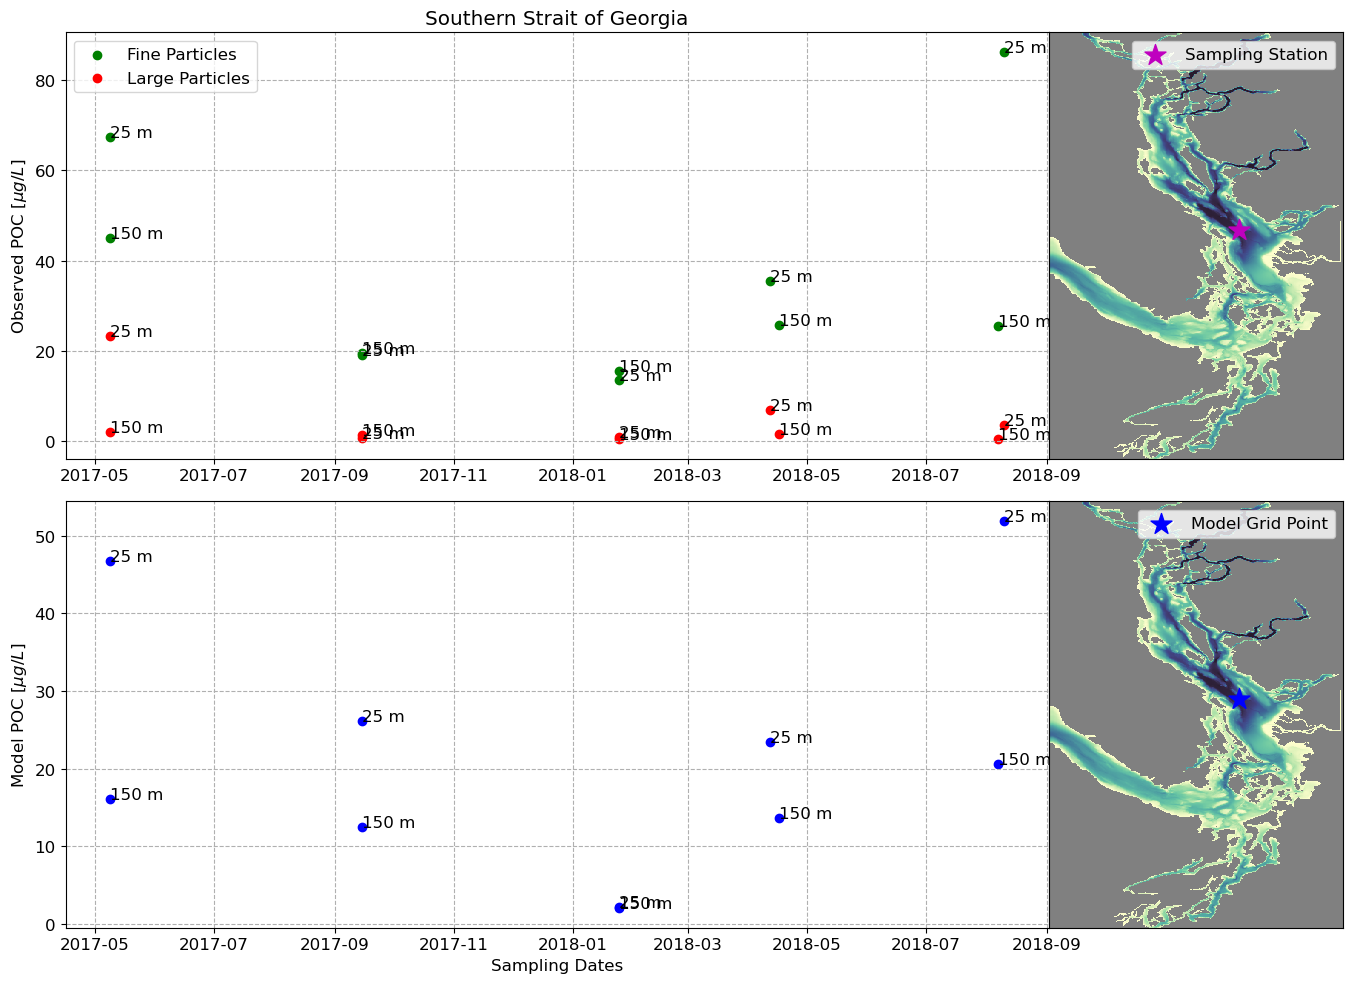

In [62]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(2,1, figsize=(14,10))
    #
    ax[0].scatter(time_SS, poc_SS_f, c = 'g', label = 'Fine Particles')
    ax[0].scatter(time_SS, poc_SS_L, c = 'r', label = 'Large Particles')
    #
    for i, txt in enumerate(dd_s):
        ax[0].annotate(txt+' m', (time_SS[i], poc_SS_f[i]))
        ax[0].annotate(txt+' m', (time_SS[i], poc_SS_L[i])) 
    #
    ax[0].grid(linestyle = '--')
    ax[0].set_ylabel(r'Observed POC [$\mu g/L$]')
    ax[0].legend()
    ax[0].set_title('Southern Strait of Georgia')
    #
    axins = ax[0].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins.scatter(gp_SS_i[0],gp_SS_j[0], c ='m', marker='*', s=250, label = 'Sampling Station')
    axins.legend()
    #
    axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    #
    # 
    ax[1].scatter(time_SS, poc_model_SS, c = 'b')
    for i, txt in enumerate(dd_s):
        ax[1].annotate(txt+' m', (time_SS[i], poc_model_SS[i])) 
    #
    ax[1].grid(linestyle = '--') 
    #
    ax[1].set_xlabel('Sampling Dates')
    ax[1].set_ylabel(r'Model POC [$\mu g/L$]')
    #
    axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins1.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins1.scatter(gp_SS_i[0],gp_SS_j[0], c ='b', marker='*', s=250, label = 'Model Grid Point')
    axins1.legend()
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()
plt.show()       

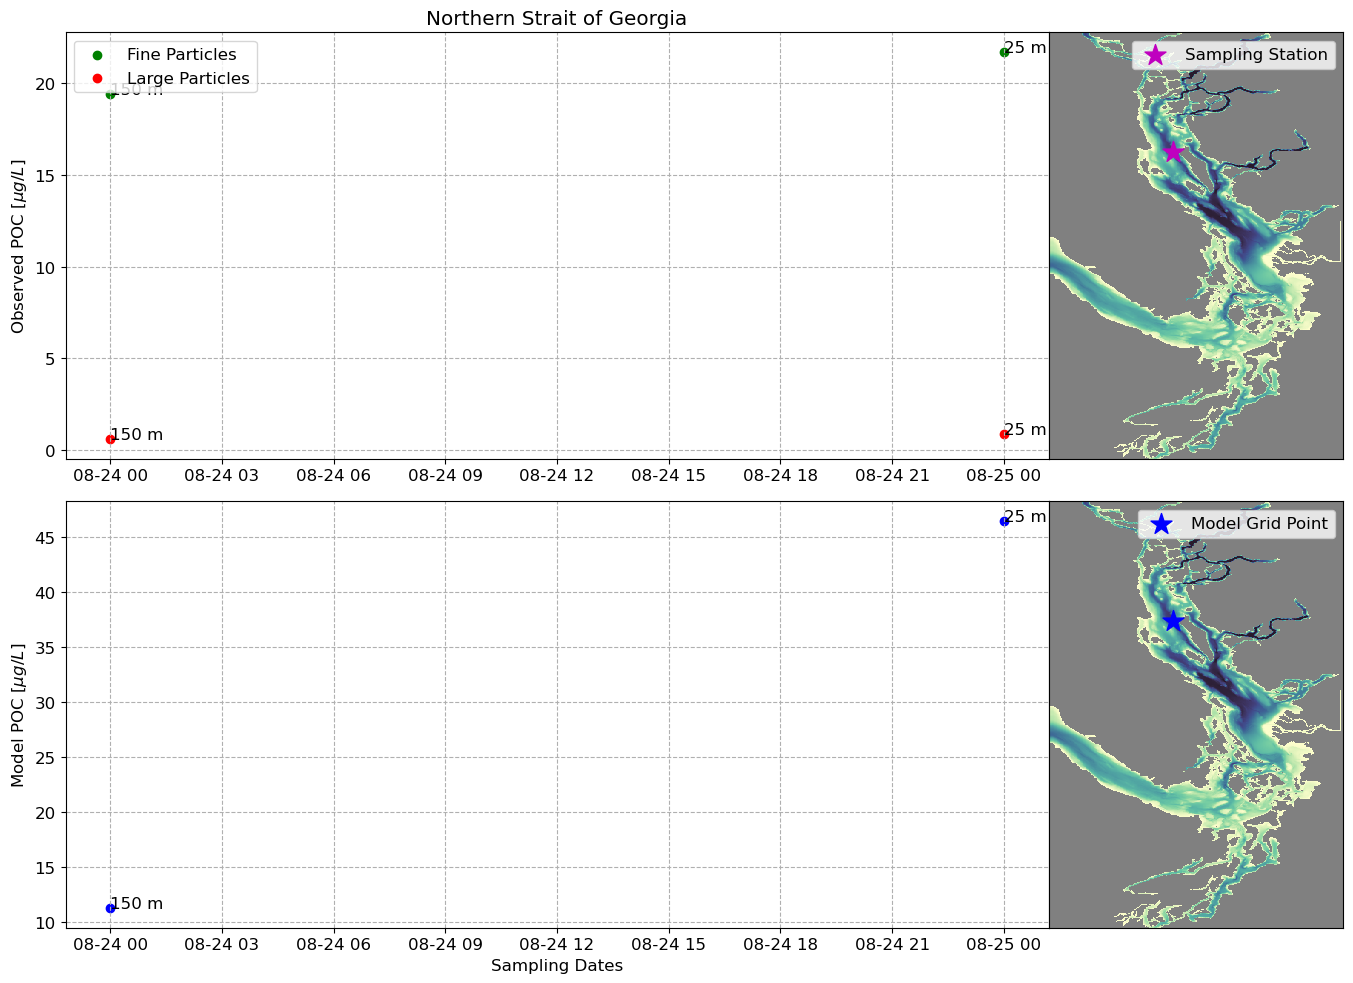

In [63]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(2,1,figsize=(14,10))
    #
    ax[0].scatter(time_NS, poc_NS_f, c = 'g', label = 'Fine Particles')
    ax[0].scatter(time_NS, poc_NS_L, c = 'r', label = 'Large Particles')
    #
    for i, txt in enumerate(dd_n):
        ax[0].annotate(txt+' m', (time_NS[i], poc_NS_f[i]))
        ax[0].annotate(txt+' m', (time_NS[i], poc_NS_L[i])) 
    #
    ax[0].grid(linestyle = '--')
    ax[0].set_ylabel(r'Observed POC [$\mu g/L$]')
    ax[0].legend()
    ax[0].set_title('Northern Strait of Georgia')
    #
    axins = ax[0].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins.scatter(gp_NS_i[0],gp_NS_j[0], c ='m', marker='*', s=250, label = 'Sampling Station')
    axins.legend()
    #
    axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################################################
    ax[1].scatter(time_NS, poc_model_NS, c = 'b')
    for i, txt in enumerate(dd_n):
        ax[1].annotate(txt+' m', (time_NS[i], poc_model_NS[i])) 
    #
    ax[1].grid(linestyle = '--') 
    #
    ax[1].set_xlabel('Sampling Dates')
    ax[1].set_ylabel(r'Model POC [$\mu g/L$]')
    #
    axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins1.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins1.scatter(gp_NS_i[0],gp_NS_j[0], c ='b', marker='*', s=250, label = 'Model Grid Point')
    axins1.legend()
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()

Difference betweeen Model and Observations

In [64]:
diff_SS_f = np.concatenate(poc_model_SS) / poc_SS_f 
diff_SS_L = np.concatenate(poc_model_SS) / poc_SS_L 
diff_NS_f = np.concatenate(poc_model_NS) / poc_NS_f
diff_NS_L = np.concatenate(poc_model_NS) / poc_NS_L

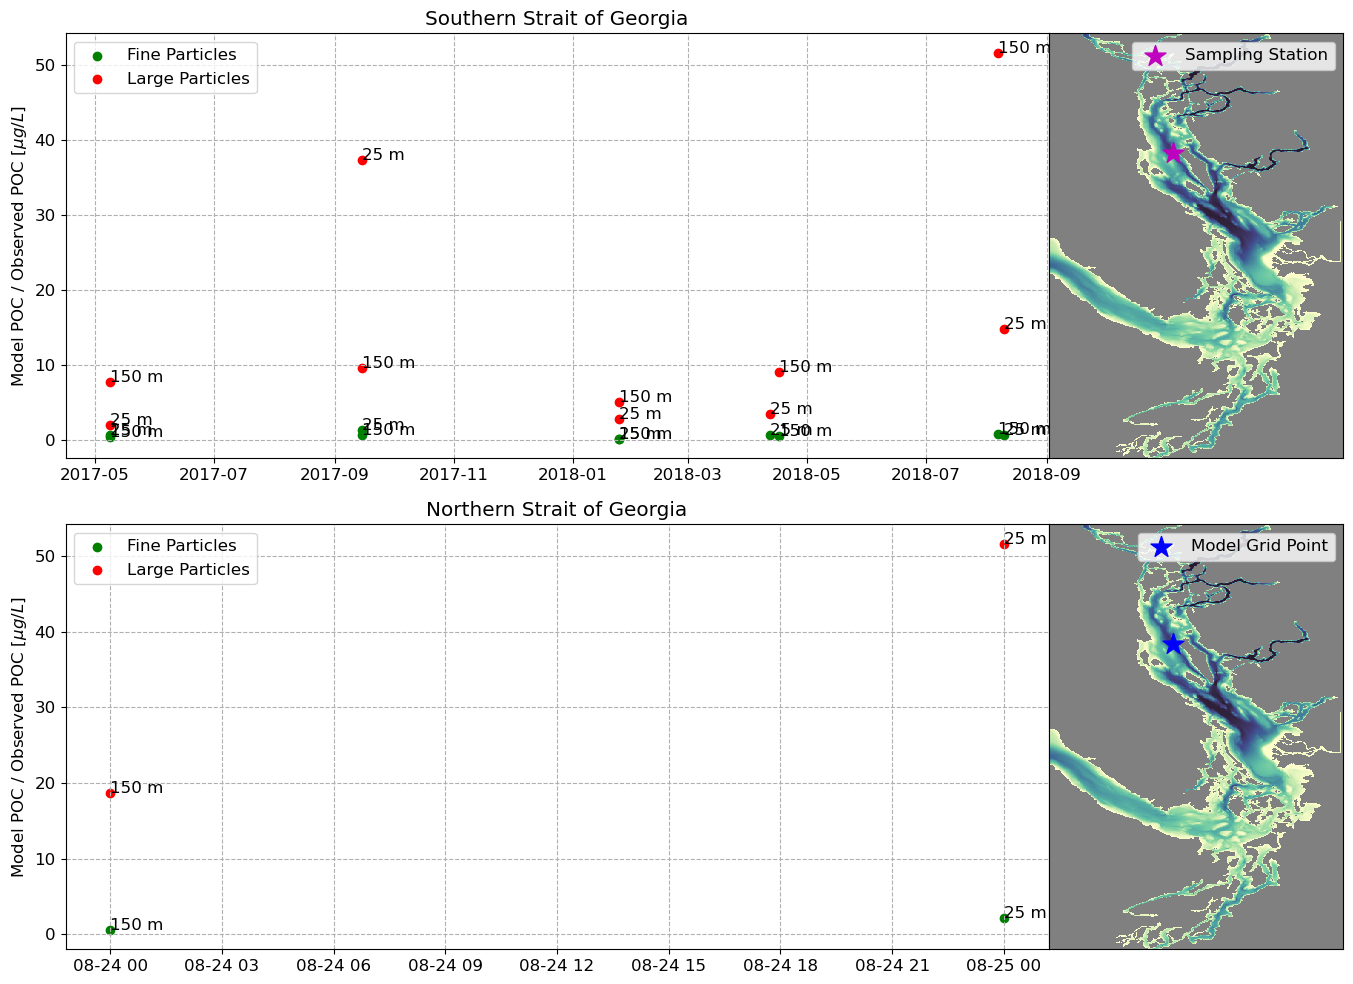

In [65]:
with plt.rc_context({'font.size': 12}):
#
    fig, ax = plt.subplots(2,1, figsize = (14, 10))
    ax[0].scatter(time_SS, diff_SS_f, c = 'g', label = 'Fine Particles')
    ax[0].scatter(time_SS, diff_SS_L, c = 'r', label = 'Large Particles')
    for i, txt in enumerate(dd_s):
        ax[0].annotate(txt+' m', (time_SS[i], diff_SS_f[i]))
        ax[0].annotate(txt+' m', (time_SS[i], diff_SS_L[i])) 
    #
    ax[0].grid(linestyle = '--')
    ax[0].set_ylabel(r'Model POC / Observed POC [$\mu g/L$]')
    ax[0].legend()
    ax[0].set_title('Southern Strait of Georgia')
    #
    axins = ax[0].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins.scatter(gp_NS_i[0],gp_NS_j[0], c ='m', marker='*', s=250, label = 'Sampling Station')
    axins.legend()
    #
    axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################################################    
    #
    #
    ax[1].scatter(time_NS, diff_NS_f, c = 'g', label = 'Fine Particles')
    ax[1].scatter(time_NS, diff_NS_L, c = 'r', label = 'Large Particles')
    #
    for i, txt in enumerate(dd_n):
        ax[1].annotate(txt+' m', (time_NS[i], diff_NS_f[i]))
        ax[1].annotate(txt+' m', (time_NS[i], diff_NS_L[i])) 
    #
    ax[1].grid(linestyle = '--')
    ax[1].set_ylabel(r'Model POC / Observed POC [$\mu g/L$]')
    ax[1].legend()
    ax[1].set_title('Northern Strait of Georgia')
    #
    axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins1.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins1.scatter(gp_NS_i[0],gp_NS_j[0], c ='b', marker='*', s=250, label = 'Model Grid Point')
    axins1.legend()
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()

Appears to be a better relation between the POC of fine particles with the one from the model

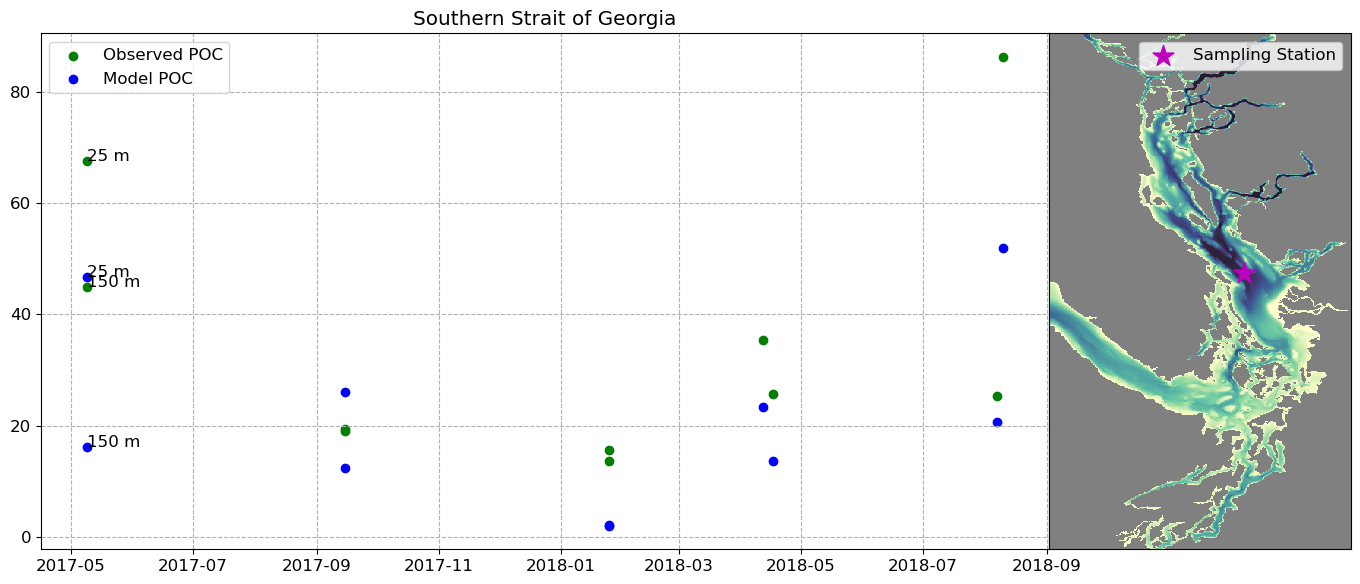

In [66]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(14,6))
    #
    ax.scatter(time_SS, poc_SS_f, c = 'g', label = 'Observed POC')
    ax.scatter(time_SS, poc_model_SS, c = 'b', label = 'Model POC')

    #
    for i, txt in enumerate(dd_n):
        ax.annotate(txt+' m', (time_SS[i], poc_SS_f[i]))
        ax.annotate(txt+' m', (time_SS[i], poc_model_SS[i])) 
    
    #
    ax.grid(linestyle = '--')
    ax.legend()
    ax.set_title('Southern Strait of Georgia')
    #
    axins = ax.inset_axes([1, 0, 0.3, 1])
    #
    prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins.scatter(gp_SS_i[0],gp_SS_j[0], c ='m', marker='*', s=250, label = 'Sampling Station')
    axins.legend()
    #
    axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    plt.tight_layout()

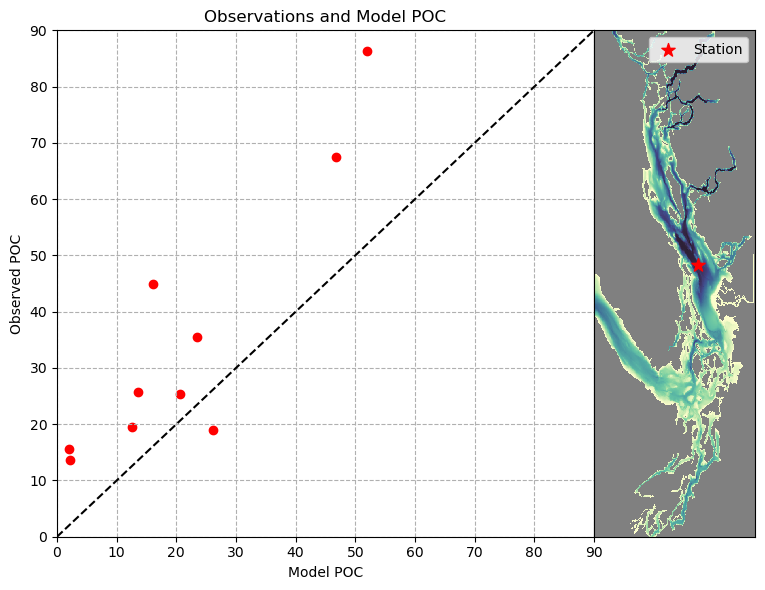

In [72]:
fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(poc_model_SS, poc_SS_f, c = 'r')
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)
ax.plot([0,90],[0,90], c = 'k', linestyle = '--')
#
ax.set_xlabel('Model POC')
ax.set_ylabel('Observed POC')
ax.set_title('Observations and Model POC')
#
ax.grid(linestyle = '--')
#
axins = ax.inset_axes([1, 0, 0.3, 1])
#
prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
axins.scatter(gp_SS_i[0],gp_SS_j[0], c ='r', marker='*', s=100, label = 'Station')
axins.legend()
#
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#
plt.tight_layout()
